In [179]:
import collections
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from river import ensemble
from river import compose
from river import preprocessing
from river import metrics
from river import tree
from river import optim
from river import imblearn
from river import linear_model

from pprint import pprint

from source.bank_dataset import BankDataset

In [180]:
sns.set(rc={'figure.figsize':(15, 5)})

In [181]:
# Creating a data frame
df = pd.read_csv("../datasets/bank-additional-full.csv", delimiter=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [182]:
bank_dataset = BankDataset()
counts = collections.Counter(y for _, y in bank_dataset)

for c, count in counts.items():
    print(f'{c}: {count} ({count / sum(counts.values()):.5%})')

no: 36548 (88.73458%)
yes: 4640 (11.26542%)


### Predict with River classification models

#### Apply data transformations

In [183]:
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
numerical_features = (feature for feature in df.columns if feature not in categorical_features + ['y'])

transform_pipeline = compose.Select(categorical_features[0])
for feature in categorical_features[1:]:
    transform_pipeline += compose.Select(feature)
transform_pipeline |= preprocessing.OneHotEncoder()

for feature in numerical_features:
    transform_pipeline += compose.Select(feature)
transform_pipeline |= preprocessing.MinMaxScaler()

for idx, (x, y) in enumerate(bank_dataset):
    print(f'Initial features: {x}\n')
    x = transform_pipeline.transform_one(x)
    print(f'Transformed features: {x}\n\n')
    if idx + 1 == 10:
        break

Initial features: {'age': 56, 'job': 'housemaid', 'marital': 'married', 'education': 'basic.4y', 'default': 'no', 'housing': 'no', 'loan': 'no', 'contact': 'telephone', 'month': 'may', 'day_of_week': 'mon', 'duration': 261, 'campaign': 1, 'pdays': 999, 'previous': 0, 'poutcome': 'nonexistent', 'emp.var.rate': 1.1, 'cons.price.idx': 93.994, 'cons.conf.idx': -36.4, 'euribor3m': 4.857, 'nr.employed': 5191.0}

Transformed features: {'nr.employed': 0.0, 'euribor3m': 0.0, 'cons.conf.idx': 0.0, 'cons.price.idx': 0.0, 'emp.var.rate': 0.0, 'previous': 0.0, 'pdays': 0.0, 'campaign': 0.0, 'duration': 0.0, 'age': 0.0, 'poutcome_nonexistent': 0.0, 'day_of_week_mon': 0.0, 'month_may': 0.0, 'contact_telephone': 0.0, 'loan_no': 0.0, 'housing_no': 0.0, 'default_no': 0.0, 'education_basic.4y': 0.0, 'marital_married': 0.0, 'job_housemaid': 0.0}


Initial features: {'age': 57, 'job': 'services', 'marital': 'married', 'education': 'high.school', 'default': 'unknown', 'housing': 'no', 'loan': 'no', 'contact

#### Predict with Adaptive Random Forest Classifier

In [184]:
def ddict2dict(d):
    for k, v in d.items():
        if isinstance(v, dict):
            d[k] = ddict2dict(v)
    return dict(d)


def evaluate_model(transform_pipeline, model):
    model = transform_pipeline | imblearn.RandomUnderSampler(
        classifier=model,
        desired_dist={0: .8, 1: .2},
        seed=42
    )

    cm = metrics.ConfusionMatrix()
    acc_metric = metrics.Accuracy()
    # Weighted-average F1 score.
    # This works by computing the F1 score per class,
    # and then performs a global weighted average by using the support of each class.
    f1_metric = metrics.WeightedF1()

    acc_metrics = []
    f1_metrics = []
    target_mapping = {
        'yes': 1,
        'no': 0
    }
    for idx, (x, y_true) in enumerate(bank_dataset):
        y_true = target_mapping[y_true]

        # Obtain the prior prediction and update the model in one go
        y_pred = model.predict_one(x)

        # Update the error metric
        if y_pred is not None:
            cm = cm.update(y_true, y_pred)
            acc_metric = acc_metric.update(y_true, y_pred)
            f1_metric = f1_metric.update(y_true, y_pred)
        if (idx + 1) % 1000 == 0:
            acc_metrics.append(acc_metric.get())
            f1_metrics.append(f1_metric.get())
            print(f'Index: {idx + 1}; {acc_metric}; {f1_metric}')

        model = model.learn_one(x=x, y=y_true)

        # if idx == 5000:
        #     break

    print('\n\n\nDebug pipeline:\n' + model.debug_one(x))

    # Plot the Accuracy results
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.grid(alpha=0.75)
    ax.plot(acc_metrics, lw=3, color='#2ecc71', alpha=0.8, label='Accuracy')
    ax.set_title(acc_metric)

    # Plot the F1 results
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.grid(alpha=0.75)
    ax.plot(f1_metrics, lw=3, color='#e74c3c', alpha=0.8, label='F1')
    ax.set_title(f1_metric)

    # Plot the F1 results
    fig, ax = plt.subplots(figsize=(10, 8))
    print('\n\nConfusion matrix:\n', cm)
    cm_dict = ddict2dict(cm.data)
    ax = sns.heatmap(pd.DataFrame(cm_dict).T, annot=True, fmt=".0f")
    ax.set(xlabel="Predicted label", ylabel="True label")
    plt.show()


Index: 1000; Accuracy: 98.10%; WeightedF1: 97.15%
Index: 2000; Accuracy: 97.95%; WeightedF1: 96.98%
Index: 3000; Accuracy: 97.60%; WeightedF1: 96.63%
Index: 4000; Accuracy: 97.10%; WeightedF1: 96.13%
Index: 5000; Accuracy: 97.04%; WeightedF1: 96.12%
Index: 6000; Accuracy: 96.97%; WeightedF1: 96.10%
Index: 7000; Accuracy: 96.94%; WeightedF1: 96.15%
Index: 8000; Accuracy: 96.80%; WeightedF1: 96.09%
Index: 9000; Accuracy: 96.68%; WeightedF1: 96.03%
Index: 10000; Accuracy: 96.54%; WeightedF1: 95.96%
Index: 11000; Accuracy: 96.50%; WeightedF1: 96.00%
Index: 12000; Accuracy: 96.47%; WeightedF1: 96.01%
Index: 13000; Accuracy: 96.34%; WeightedF1: 95.89%
Index: 14000; Accuracy: 96.17%; WeightedF1: 95.81%
Index: 15000; Accuracy: 95.92%; WeightedF1: 95.62%
Index: 16000; Accuracy: 95.66%; WeightedF1: 95.45%
Index: 17000; Accuracy: 95.46%; WeightedF1: 95.34%
Index: 18000; Accuracy: 95.33%; WeightedF1: 95.22%
Index: 19000; Accuracy: 95.33%; WeightedF1: 95.24%
Index: 20000; Accuracy: 95.27%; Weighted

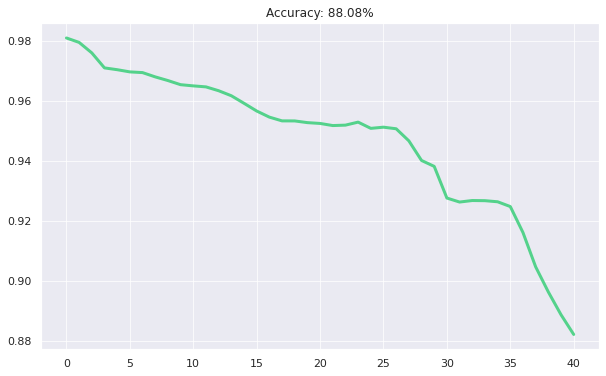

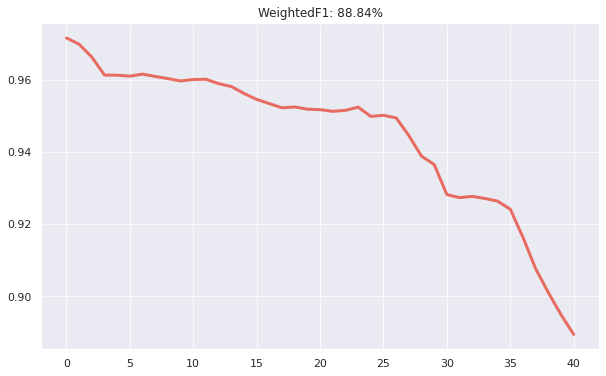

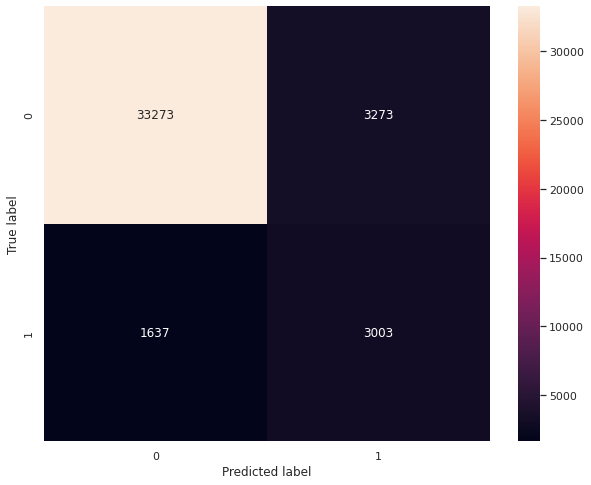

In [185]:
# ARF_model = transform_pipeline | ensemble.AdaptiveRandomForestClassifier(seed=42, leaf_prediction="mc")
ARF_model = ensemble.AdaptiveRandomForestClassifier(seed=42, leaf_prediction="mc")
evaluate_model(transform_pipeline, ARF_model)

#### Predict with Streaming Random Patches ensemble classifier

Index: 1000; Accuracy: 97.90%; WeightedF1: 97.58%
Index: 2000; Accuracy: 97.65%; WeightedF1: 97.26%
Index: 3000; Accuracy: 97.30%; WeightedF1: 96.72%
Index: 4000; Accuracy: 97.00%; WeightedF1: 96.32%
Index: 5000; Accuracy: 96.96%; WeightedF1: 96.33%
Index: 6000; Accuracy: 96.85%; WeightedF1: 96.14%
Index: 7000; Accuracy: 96.90%; WeightedF1: 96.21%
Index: 8000; Accuracy: 96.74%; WeightedF1: 96.01%
Index: 9000; Accuracy: 96.62%; WeightedF1: 95.84%
Index: 10000; Accuracy: 96.51%; WeightedF1: 95.71%
Index: 11000; Accuracy: 96.45%; WeightedF1: 95.69%
Index: 12000; Accuracy: 96.37%; WeightedF1: 95.61%
Index: 13000; Accuracy: 96.27%; WeightedF1: 95.53%
Index: 14000; Accuracy: 96.07%; WeightedF1: 95.38%
Index: 15000; Accuracy: 95.88%; WeightedF1: 95.19%
Index: 16000; Accuracy: 95.68%; WeightedF1: 95.00%
Index: 17000; Accuracy: 95.62%; WeightedF1: 94.95%
Index: 18000; Accuracy: 95.56%; WeightedF1: 94.90%
Index: 19000; Accuracy: 95.61%; WeightedF1: 94.95%
Index: 20000; Accuracy: 95.51%; Weighted

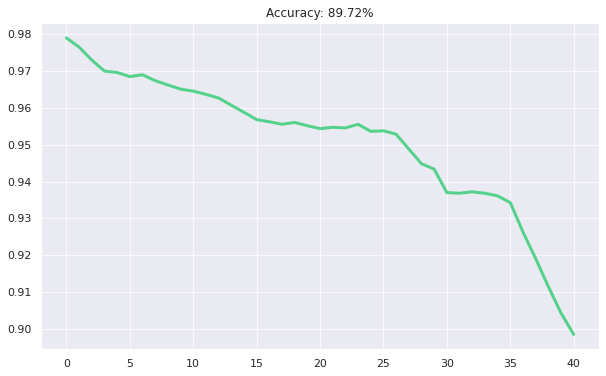

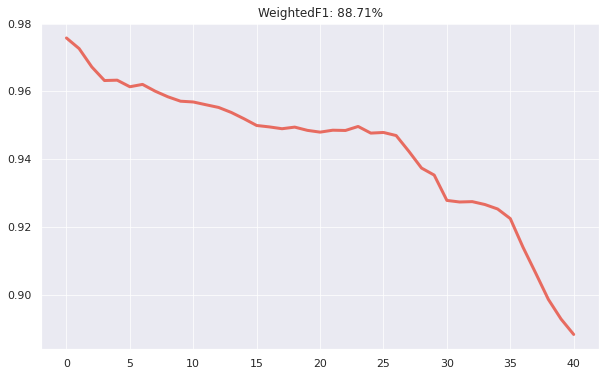

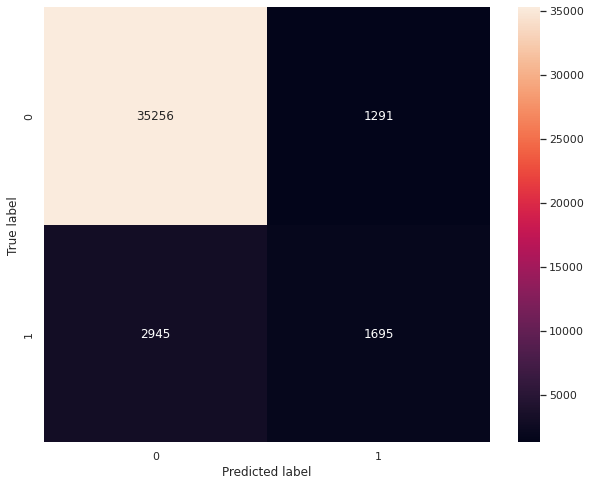

In [132]:
base_model = tree.HoeffdingTreeClassifier(
     grace_period=50, delta=0.01
)
SRP_model_obj = ensemble.SRPClassifier(
     model=base_model, n_models=3, seed=42
)
SRP_model = transform_pipeline | SRP_model_obj
evaluate_model(SRP_model)

In [ ]:
from river import evaluate

evaluate.progressive_val_score()